# Filler Word Detection Model

## Data synthesis: Creating a speech dataset
### 1.1 - Listening to the data

In [126]:

play(negatives[0])

Importing Libraries...

In [127]:
import numpy as np
from pydub import AudioSegment
from pydub.playback import play
import random
import sys
import io
import os
import glob
import IPython
import wave
import pylab
from tf_utils import *
import matplotlib.pyplot as plt

Declaring Environment Variables...

In [145]:
POSITIVE_DIRECTORY = "./raw_data/positive_data/"
BACKGROUND_DIRECTORY = "./raw_data/background_data/"
NEGATIVES_DIRECTORY = "./raw_data/google_dataset/"
NEGATIVES_TRUNCATED_DIRECTORY = "./raw_data/google_dataset_truncated/"
AUDIO_EXAMPLES_DIRECTORY = "./audio_examples/"
POSITIVE_EXAMPLE = "jh_1.wav"
AUDIO_EXAMPLE = "example_train.wav"

Helper functions for spectogram...

In [129]:
def graph_spectrogram(wav_file):
    sound_info, frame_rate = get_wav_info(wav_file)
    pylab.figure(num=None, figsize=(19, 12))
    pylab.subplot(111)
    pylab.title('spectrogram of %r' % wav_file)
    pylab.specgram(sound_info, Fs=frame_rate)
    pylab.savefig('spectrogram.png')
def get_wav_info(wav_file):
    wav = wave.open(wav_file, 'r')
    frames = wav.readframes(-1)
    sound_info = pylab.fromstring(frames, 'int16')
    frame_rate = wav.getframerate()
    wav.close()
    return sound_info, frame_rate

Loading raw audio files...

In [130]:
play(AudioSegment.from_file(POSITIVE_DIRECTORY + POSITIVE_EXAMPLE))

## 1.2 - From audio recordings to spectograms

In [148]:
play(AudioSegment.from_file(AUDIO_EXAMPLES_DIRECTORY + AUDIO_EXAMPLE, format="wav"))

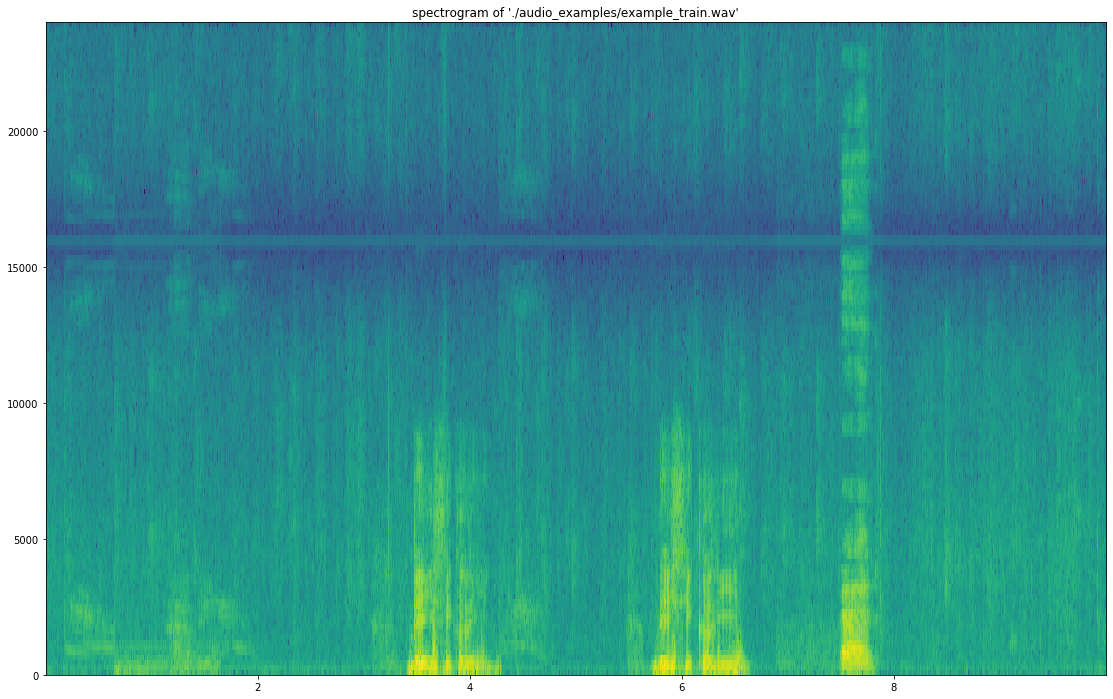

In [150]:
x = graph_spectrogram(AUDIO_EXAMPLES_DIRECTORY + AUDIO_EXAMPLE)

In [151]:
_, data = wavfile.read("audio_examples/example_train.wav")
print("Time steps in audio recording before spectrogram", data[:,0].shape)
print("Time steps in input after spectrogram", x.shape)

IndexError: too many indices for array

In [131]:
Tx = x.shape[1] # The number of time steps input to the model from the spectrogram
n_freq = x.shape[0] # Number of frequencies input to the model at each time step of the spectrogram


In [ ]:
Ty = 1375 # The number of time steps in the output of our model

## 1.3 - Generating a single training example
Note that 1.2 is skipped because we need to first have a training example before we can graph its spectogram.

In [132]:
# Load raw audio files for speech synthesis
def load_raw_audio(positiveDirectory, backgroundDirectory, negativesDirectory):
    BACKGROUND_DIRECTORY_IN_GOOGLE_DATASET = "_background_noise_/"
    positives = []
    backgrounds = []
    negatives = []
    for filename in os.listdir(positiveDirectory):
        if filename.endswith("wav"):
            activate = AudioSegment.from_wav(positiveDirectory + filename)
            positives.append(activate)
    for filename in os.listdir(backgroundDirectory):
        if filename.endswith("wav"):
            background = AudioSegment.from_wav(backgroundDirectory + filename)
            backgrounds.append(background)
    for directory in os.listdir(negativesDirectory):
        if os.path.isdir(os.path.join(negativesDirectory, directory)) and directory != BACKGROUND_DIRECTORY_IN_GOOGLE_DATASET: # Excludes background directory in google dataset
            for filename in os.listdir(negativesDirectory + directory):
                if filename.endswith("wav"):
                    negative = AudioSegment.from_wav(negativesDirectory + directory + "/" + filename)
                    negatives.append(negative)
    return positives, negatives, backgrounds



In [133]:
# Load audio segments using pydub 
# positives, negatives, backgrounds = load_raw_audio(POSITIVE_DIRECTORY, BACKGROUND_DIRECTORY, NEGATIVES_DIRECTORY)  # Actual dataset. Use this for production.
positives, negatives, backgrounds = load_raw_audio(POSITIVE_DIRECTORY, BACKGROUND_DIRECTORY, NEGATIVES_TRUNCATED_DIRECTORY) # Truncated negative dataset. Use this to save time.

assert len(backgrounds[0]) == 10000, "Should be 10,000 since it is a 10s clip"
assert 0 < len(positives[0]) < 2000, "Maybe around 1000, since a positive audio clip is usually around 1 sec (but varies a lot)"
assert 0 < len(negatives[0]) < 2000, "Maybe around 1000, since a negative audio clip is usually around 1 sec (but varies a lot)"

\[OPTIONAL\] Playing audio clips...

In [134]:
# play(backgrounds[0])
# play(positives[0])
# play(negatives[0])

In [135]:
def get_random_time_segment(segment_ms):
    """
    Gets a random time segment of duration segment_ms in a 10,000 ms audio clip.
    
    Arguments:
    segment_ms -- the duration of the audio clip in ms ("ms" stands for "milliseconds")
    
    Returns:
    segment_time -- a tuple of (segment_start, segment_end) in ms
    """
    
    segment_start = np.random.randint(low=0, high=10000-segment_ms)   # Make sure segment doesn't run past the 10sec background 
    segment_end = segment_start + segment_ms - 1
    
    return (segment_start, segment_end)

In [136]:
def is_overlapping(segment_time, previous_segments):
    """
    Checks if the time of a segment overlaps with the times of existing segments.
    
    Arguments:
    segment_time -- a tuple of (segment_start, segment_end) for the new segment
    previous_segments -- a list of tuples of (segment_start, segment_end) for the existing segments
    
    Returns:
    True if the time segment overlaps with any of the existing segments, False otherwise
    """
    
    segment_start, segment_end = segment_time
    
    ### START CODE HERE ### (≈ 4 line)
    # Step 1: Initialize overlap as a "False" flag. (≈ 1 line)
    overlap = False
    
    # Step 2: loop over the previous_segments start and end times.
    # Compare start/end times and set the flag to True if there is an overlap (≈ 3 lines)
    for previous_start, previous_end in previous_segments:
        if segment_start <= previous_end and segment_end >= previous_start:
            overlap = True
    ### END CODE HERE ###

    return overlap

overlap1 = is_overlapping((950, 1430), [(2000, 2550), (260, 949)])
overlap2 = is_overlapping((2305, 2950), [(824, 1532), (1900, 2305), (3424, 3656)])

assert overlap1 == False, "Should not overlap."
assert overlap2 == True, "Should overlap."

In [137]:

def insert_audio_clip(background, audio_clip, previous_segments):
    """
    Insert a new audio segment over the background noise at a random time step, ensuring that the 
    audio segment does not overlap with existing segments.
    
    Arguments:
    background -- a 10 second background audio recording.  
    audio_clip -- the audio clip to be inserted/overlaid. 
    previous_segments -- times where audio segments have already been placed
    
    Returns:
    new_background -- the updated background audio
    """
    
    # Get the duration of the audio clip in ms
    segment_ms = len(audio_clip)
    
    ### START CODE HERE ### 
    # Step 1: Use one of the helper functions to pick a random time segment onto which to insert 
    # the new audio clip. (≈ 1 line)
    segment_time = get_random_time_segment(segment_ms)
    
    # Step 2: Check if the new segment_time overlaps with one of the previous_segments. If so, keep 
    # picking new segment_time at random until it doesn't overlap. (≈ 2 lines)
    while is_overlapping(segment_time, previous_segments):
        segment_time = get_random_time_segment(segment_ms)

    # Step 3: Add the new segment_time to the list of previous_segments (≈ 1 line)
    previous_segments.append(segment_time)
    ### END CODE HERE ###
    
    # Step 4: Superpose audio segment and background
    new_background = background.overlay(audio_clip, position = segment_time[0])
    
    return new_background, segment_time

In [138]:
np.random.seed(5)
audio_clip, segment_time = insert_audio_clip(backgrounds[0], positives[0], [(3790, 4400)])
audio_clip.export("insert_test.wav", format="wav")
print("Segment Time: ", segment_time)
play(AudioSegment.from_file("insert_test.wav", format="wav"))

Segment Time:  (2254, 3421)


In [139]:
def insert_ones(y, segment_end_ms):
    """
    Update the label vector y. The labels of the 50 output steps strictly after the end of the segment 
    should be set to 1. By strictly we mean that the label of segment_end_y should be 0 while, the
    50 followinf labels should be ones.
    
    
    Arguments:
    y -- numpy array of shape (1, Ty), the labels of the training example
    segment_end_ms -- the end time of the segment in ms
    
    Returns:
    y -- updated labels
    """
    
    # duration of the background (in terms of spectrogram time-steps)
    segment_end_y = int(segment_end_ms * Ty / 10000.0)
    
    # Add 1 to the correct index in the background label (y)
    ### START CODE HERE ### (≈ 3 lines)
    for i in range(segment_end_y + 1, segment_end_y + 51):
        if i < Ty:
            y[0, i] = 1
    ### END CODE HERE ###
    
    return y
    

sanity checks: 0.0 1.0 0.0


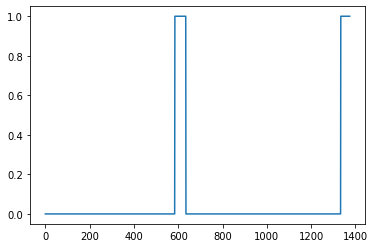

In [140]:
arr1 = insert_ones(np.zeros((1, Ty)), 9700)
plt.plot(insert_ones(arr1, 4251)[0,:])
print("sanity checks:", arr1[0][1333], arr1[0][634], arr1[0][635])

In [121]:
def create_training_example(background, positives, negatives):
    """
    Creates a training example with a given background, positives, and negatives.
    
    Arguments:
    background -- a 10 second background audio recording
    positives -- a list of audio segments of the word "activate"
    negatives -- a list of audio segments of random words that are not "activate"
    
    Returns:
    x -- the spectrogram of the training example
    y -- the label at each time step of the spectrogram
    """
    
    # Set the random seed
    np.random.seed(18)
    
    # Make background quieter - commented out as background is already very soft
    # background = background - 20

    ### START CODE HERE ###
    # Step 1: Initialize y (label vector) of zeros (≈ 1 line)
    y = np.zeros((1, Ty))

    # Step 2: Initialize segment times as empty list (≈ 1 line)
    previous_segments = []
    ### END CODE HERE ###
    
    # Select 0-4 random "activate" audio clips from the entire list of "positives" recordings
    number_of_positives = np.random.randint(0, 5)
    random_indices = np.random.randint(len(positives), size=number_of_positives)
    random_positives = [positives[i] for i in random_indices]
    
    # Step 3: Loop over randomly selected "activate" clips and insert in background
    for random_activate in random_positives:
        # Insert the audio clip on the background
        background, segment_time = insert_audio_clip(background, random_activate, previous_segments)
        # Retrieve segment_start and segment_end from segment_time
        segment_start, segment_end = segment_time
        # Insert labels in "y"
        y = insert_ones(y, segment_end_ms=segment_end)

    # Select 0-2 random negatives audio recordings from the entire list of "negatives" recordings
    number_of_negatives = np.random.randint(0, 3)
    random_indices = np.random.randint(len(negatives), size=number_of_negatives)
    random_negatives = [negatives[i] for i in random_indices]

    # Step 4: Loop over randomly selected negative clips and insert in background
    for random_negative in random_negatives:
        # Insert the audio clip on the background 
        background, _ = insert_audio_clip(background, random_negative, previous_segments)
    
    # Standardize the volume of the audio clip 
    # background = match_target_amplitude(background, -20.0)

    # Export new training example 
    file_handle = background.export("train" + ".wav", format="wav")
    print("File (train.wav) was saved in your directory.")
    
    # Get and plot spectrogram of the new recording (background with superposition of positive and negatives)
    x = graph_spectrogram("train.wav")
    
    return x, y

File (train.wav) was saved in your directory.


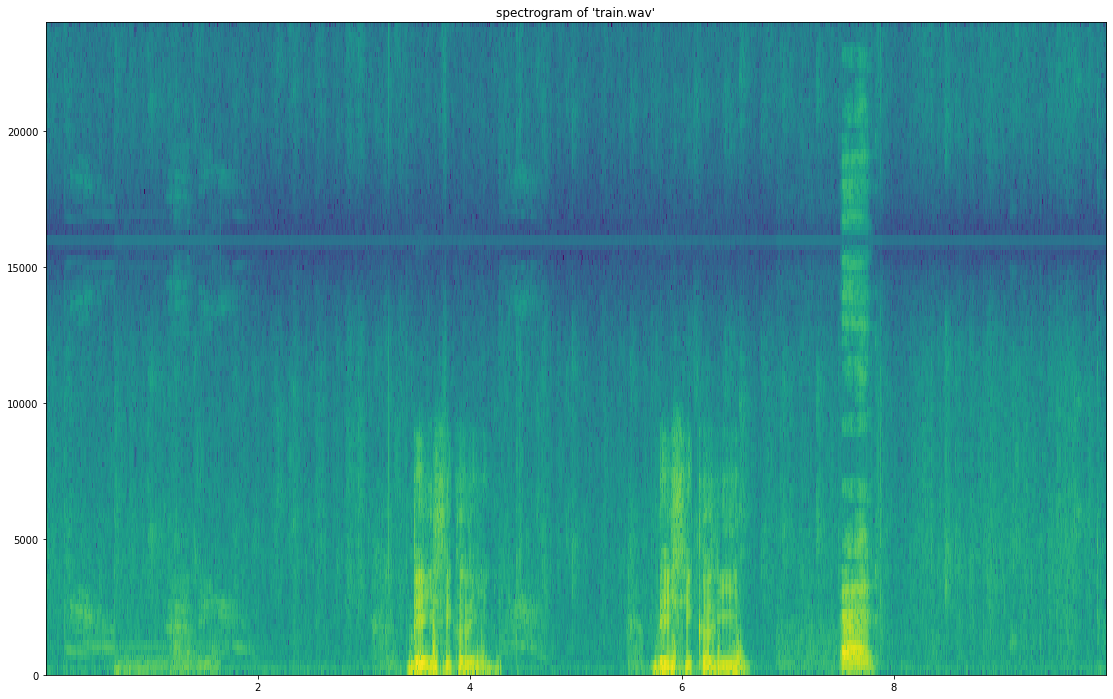

In [141]:
x, y = create_training_example(backgrounds[0], positives, negatives)

In [143]:
play(AudioSegment.from_file("train.wav", format="wav"))

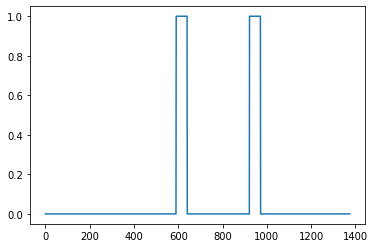

In [91]:
plt.plot(y[0])

\[Optional\] Plotting spectrogram...